In [2]:
import pandas as pd
df = pd.read_csv('../splitData/train1.csv', index_col=0)
df.head()


,NG Tube (Y/N),X Coordinate,Y Coordinate
Identifier,,,
589,N,NaN,NaN
405,Y,1534.087,2508.870
285,N,NaN,NaN
1115,Y,2039.728,848.841
1884,N,NaN,NaN


In [207]:
import pandas as pd
import imageio
import numpy as np
import os

strImgDir = '../PNG2048/'

size = 512
nPatches = 20
nPad = 128
nPosPatchesMin = 10

def extract_patches(strCoordFile, strOutDir, strOutCoord):
    dfCoords = pd.read_csv(strCoordFile, index_col=0)
    dfLabels = pd.DataFrame(columns=['tube', 'xMin', 'xMax', 'yMin', 'yMax', 'xCenter', 'yCenter', 'xTube', 'yTube'])

    for idx, row in dfCoords.iterrows():
        strImgPath = os.path.join(strImgDir, '{:04d}.png'.format(idx))
        if not os.path.exists(strImgPath):
            continue
        image = imageio.imread(strImgPath)
        imSize = image.shape
        coords = row[['X Coordinate', 'Y Coordinate']].values * imSize
        xCoord = coords[0]
        yCoord = coords[1]
        nPosPatches = 0
        nNegPatches = 0
        for i in range(nPatches):
            xMin = np.random.randint(size//2, imSize[1] - size - 1)
            xMax = xMin + size
            yMin = np.random.randint(size//2, imSize[0] - size - 1)
            yMax = yMin + size
            patch = image[yMin:yMax, xMin:xMax]
            strOutPath = os.path.join(strOutDir, '{:04d}_{:02d}.png'.format(idx, i))
            imageio.imwrite(strOutPath, patch)
            # check if tube in patch
            if (xMin < xCoord) & (xMax > xCoord) & (yMin < yCoord) & (yMax > yCoord):
                tube = 'Y'
                nPosPatches += 1
                xTube = (xCoord - xMin) / size
                yTube = (yCoord - yMin) / size
            else:
                tube = 'N'
                nNegPatches += 1
                xTube = np.nan
                yTube = np.nan
            dfLabels.loc['{:04d}_{:02d}'.format(idx, i)] = {'tube': tube,
                                                            'xMin': xMin,
                                                           'xMax': xMax,
                                                           'yMin': yMin,
                                                           'yMax': yMax,
                                                           'xCenter': (xMax + xMin) // 2,
                                                           'yCenter': (yMax + yMin) // 2,
                                                           'xTube': xTube,
                                                           'yTube': yTube}
        if (nPosPatches < nPosPatchesMin) & (row['NG Tube (Y/N)'] == 'Y'):
            xRangeMin = int(xCoord - size + nPad)
            xRangeMin = max(0, xRangeMin)
            xRangeMax = min(xCoord - nPad, imSize[1] - size - 1)
            
            yRangeMin = int(yCoord - size + nPad)
            yRangeMin = max(0, yRangeMin)
            yRangeMax = min(yCoord - nPad, imSize[0] - size - 1)
            
            if (xRangeMax <= xRangeMin) | (yRangeMax <= yRangeMin):
                # if the tube is too close to the edge, just skip for now
                continue
            
            for j in range(i+1, i + 1 + nPosPatchesMin - nPosPatches):

                xMin = np.random.randint(xRangeMin, xRangeMax)
                xMax = xMin + size
                
                yMin = np.random.randint(yRangeMin, yRangeMax)
                yMax = yMin + size
                patch = image[yMin:yMax, xMin:xMax]
                strOutPath = os.path.join(strOutDir, '{:04d}_{:02d}.png'.format(idx, j))
                imageio.imwrite(strOutPath, patch)
                # check if tube in patch
                tube = 'Y'
                nPosPatches += 1
                xTube = (xCoord - xMin) / size
                yTube = (yCoord - yMin) / size

                dfLabels.loc['{:04d}_{:02d}'.format(idx, j)] = {'tube': tube,
                                                                'xMin': xMin,
                                                               'xMax': xMax,
                                                               'yMin': yMin,
                                                               'yMax': yMax,
                                                               'xCenter': (xMax + xMin) // 2,
                                                               'yCenter': (yMax + yMin) // 2,
                                                               'xTube': xTube,
                                                               'yTube': yTube}
    dfLabels.to_csv(strOutCoord)

In [211]:
lsInputs = [('train1.csv', './train1_patches', './train1_patches.csv'),
            ('train2.csv', './train2_patches', './train2_patches.csv'),
            ('train3.csv', './train3_patches', './train3_patches.csv'),
            ('valData.csv', './val_patches', './val_patches.csv')
           ]
def wrapper(tup):
    os.makedirs(tup[1], exist_ok=True)
    extract_patches(tup[0], tup[1], tup[2])
import multiprocessing as mp
with mp.Pool(3) as pool:
    pool.map(wrapper, lsInputs)

In [215]:
# sort into keras-style directories
import shutil
for tup in lsInputs[:-1]:
    strCsvPath = tup[2]
    strImageDir = tup[1]

    df = pd.read_csv(strCsvPath, index_col=0)
    for idx, row in df.iterrows():
        strImagePath = os.path.join(strImageDir, '{}.png'.format(idx))
        if row['tube'] == 'Y':
            strOutDir = os.path.join('./all_train/pos')
        else:
            strOutDir = os.path.join('./all_train/neg')
        shutil.copy(strImagePath, strOutDir)

In [216]:
strCsvPath = 'val_patches.csv'
strImageDir = './val_patches'
df = pd.read_csv(strCsvPath, index_col=0)
for idx, row in df.iterrows():
    strImagePath = os.path.join(strImageDir, '{}.png'.format(idx))
    if row['tube'] == 'Y':
        strOutDir = os.path.join('./all_val/pos')
    else:
        strOutDir = os.path.join('./all_val/neg')
    shutil.copy(strImagePath, strOutDir)

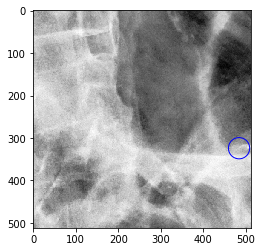

In [199]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches
def show(img, points, s=50):
    fig, ax = plt.subplots(1, 1)
    ax.imshow(img, cmap='Greys_r')
    ax.add_artist(patches.Ellipse(points, s, s, fill=False, edgecolor='blue'))
    
image = imageio.imread('train1_patches/0405_26.png')
arrCoords = dfLabels[['xTube', 'yTube']].loc['0405_26'].values
show(image, arrCoords * 512)

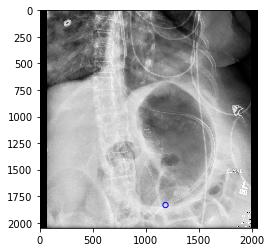

In [104]:
show(imageio.imread('../PNG2048/0405.png'), dfCoords[['X Coordinate', 'Y Coordinate']].loc[405] * 2048)